In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Define Time Period and Parameters

In [2]:
START_DATE = dt.datetime(1970,1,1)
END_DATE = dt.datetime(2020,12,31)
T = 12

# Define Asset Allocation

In [3]:
portfolios = {'GEM': ['SPY', 'VEU', 'BND'],
              'GBM': ['SPY', 'VEU', 'BND'],
             'benchmark': ['SPY'],
             'sixtyForty': ['SPY', 'BND'],
             'Permanent': ['VTI', 'BIL', 'TLT', 'GLD']}
momentum = ['GEM', 'GBM']
fixed_portfolio = ['sixtyForty']

# Get Price Data

In [4]:
combined_assets = []

for portfolio in portfolios.keys():
    combined_assets = combined_assets + portfolios[portfolio]

combined_assets = list(set(combined_assets))
combined_assets

['VTI', 'VEU', 'TLT', 'BND', 'GLD', 'SPY', 'BIL']

In [5]:
prices = pd.DataFrame()
for asset in combined_assets:
    prices[asset] = web.DataReader(asset, 'yahoo', START_DATE, END_DATE)['Adj Close']
prices.dropna(inplace=True)
prices.reset_index(inplace=True)

## Convert Daily Prices to Monthly Prices

In [6]:
prices['STD_YM'] = prices['Date'].map(lambda x : dt.datetime.strftime(x, '%Y-%m'))

In [7]:
month_list = prices['STD_YM'].unique()
monthly_prices = pd.DataFrame()
for m in month_list:
    monthly_prices = monthly_prices.append(prices[prices['STD_YM'] == m].iloc[-1,:])

In [8]:
monthly_prices = monthly_prices.drop(columns=['STD_YM'], axis=1)

In [9]:
monthly_prices.set_index('Date', inplace=True)
monthly_prices

,BIL,BND,GLD,SPY,TLT,VEU,VTI
Date,,,,,,,
2007-05-31,83.782814,48.424404,65.540001,115.558426,56.901436,38.896065,58.076099
2007-06-29,84.148705,48.273643,64.269997,113.868820,56.324764,39.157101,57.052353
2007-07-31,84.484917,48.718903,65.790001,110.303612,58.194202,38.703709,55.035744
2007-08-31,84.844711,49.441586,66.519997,111.719093,59.234501,38.628139,55.845463
2007-09-28,85.005806,49.739933,73.510002,116.044205,59.369717,41.005047,57.993641
...,...,...,...,...,...,...,...
2020-08-31,91.537003,87.302452,184.830002,345.309570,160.952271,50.784927,175.257431
2020-09-30,91.516998,87.216446,177.119995,332.379944,162.197098,49.925625,169.057571
2020-10-30,91.527000,86.731201,176.199997,324.092499,156.706390,48.896431,165.761993


## 1. GEM Portfolio

In [10]:
gem_prices = pd.DataFrame()
for col in monthly_prices.columns:
    if col in portfolios['GEM']:
        gem_prices[col] = monthly_prices[col]
gem_prices

,BND,SPY,VEU
Date,,,
2007-05-31,48.424404,115.558426,38.896065
2007-06-29,48.273643,113.868820,39.157101
2007-07-31,48.718903,110.303612,38.703709
2007-08-31,49.441586,111.719093,38.628139
2007-09-28,49.739933,116.044205,41.005047
...,...,...,...
2020-08-31,87.302452,345.309570,50.784927
2020-09-30,87.216446,332.379944,49.925625
2020-10-30,86.731201,324.092499,48.896431


In [11]:
monthly_momentum = gem_prices.copy()
monthly_momentum = monthly_momentum.apply(lambda x: x.shift(1)/x.shift(12) - 1, axis=0)
monthly_momentum.dropna(inplace=True)
monthly_momentum.head(20)

,BND,SPY,VEU
Date,,,
2008-05-30,0.080757,-0.080685,0.017123
2008-06-30,0.073358,-0.052941,0.024677
2008-07-31,0.063994,-0.104040,-0.050157
2008-08-29,0.048662,-0.123340,-0.083281
2008-09-30,0.051105,-0.142972,-0.180528
2008-10-31,0.036163,-0.234072,-0.325700
2008-11-28,-0.013697,-0.334830,-0.451992
2008-12-31,0.016429,-0.374082,-0.478587
2009-01-30,0.055408,-0.327276,-0.386839


In [12]:
rank_df = monthly_momentum.rank(axis=1)
for col in rank_df.columns:
    rank_df[col] = np.where(rank_df[col] > 2, 1, 0)
rank_df

,BND,SPY,VEU
Date,,,
2008-05-30,1,0,0
2008-06-30,1,0,0
2008-07-31,1,0,0
2008-08-29,1,0,0
2008-09-30,1,0,0
...,...,...,...
2020-08-31,0,1,0
2020-09-30,0,1,0
2020-10-30,0,1,0


In [13]:
monthly_gem_returns = gem_prices.pct_change()
monthly_gem_returns.dropna(inplace=True)
monthly_gem_returns = monthly_gem_returns[rank_df.index[0].strftime('%Y-%m-%d'):]
monthly_gem_returns

,BND,SPY,VEU
Date,,,
2008-05-30,-0.009938,0.015117,0.014188
2008-06-30,0.000420,-0.083576,-0.083765
2008-07-31,0.000210,-0.008986,-0.036758
2008-08-29,0.008378,0.015454,-0.051076
2008-09-30,-0.005156,-0.094174,-0.124768
...,...,...,...
2020-08-31,-0.009418,0.069797,0.044058
2020-09-30,-0.000985,-0.037444,-0.016920
2020-10-30,-0.005564,-0.024934,-0.020615


In [14]:
port = np.multiply(rank_df, monthly_gem_returns)

In [15]:
port_returns = port.sum(axis=1)
port_returns

Date
2008-05-30   -0.009938
2008-06-30    0.000420
2008-07-31    0.000210
2008-08-29    0.008378
2008-09-30   -0.005156
                ...   
2020-08-31    0.069797
2020-09-30   -0.037444
2020-10-30   -0.024934
2020-11-30    0.012135
2020-12-31    0.037048
Length: 152, dtype: float64

In [16]:
port_cum_returns = np.exp(np.log1p(port_returns).cumsum())
port_cum_returns

Date
2008-05-30    0.990062
2008-06-30    0.990477
2008-07-31    0.990685
2008-08-29    0.998986
2008-09-30    0.993835
                ...   
2020-08-31    1.770306
2020-09-30    1.704019
2020-10-30    1.661532
2020-11-30    1.681695
2020-12-31    1.743999
Length: 152, dtype: float64

## 2. GBM Portfolio

In [17]:
gbm_prices = pd.DataFrame()
for col in monthly_prices.columns:
    if col in portfolios['GBM']:
        gbm_prices[col] = monthly_prices[col]
gbm_prices

,BND,SPY,VEU
Date,,,
2007-05-31,48.424404,115.558426,38.896065
2007-06-29,48.273643,113.868820,39.157101
2007-07-31,48.718903,110.303612,38.703709
2007-08-31,49.441586,111.719093,38.628139
2007-09-28,49.739933,116.044205,41.005047
...,...,...,...
2020-08-31,87.302452,345.309570,50.784927
2020-09-30,87.216446,332.379944,49.925625
2020-10-30,86.731201,324.092499,48.896431


In [18]:
gbm_momentum = gbm_prices.copy()
gbm_momentum = gbm_momentum.apply(lambda x: x.shift(1)/x.shift(12) - 1, axis=0)
gbm_momentum.dropna(inplace=True)
gbm_momentum

,BND,SPY,VEU
Date,,,
2008-05-30,0.080757,-0.080685,0.017123
2008-06-30,0.073358,-0.052941,0.024677
2008-07-31,0.063994,-0.104040,-0.050157
2008-08-29,0.048662,-0.123340,-0.083281
2008-09-30,0.051105,-0.142972,-0.180528
...,...,...,...
2020-08-31,0.075741,0.138787,0.039411
2020-09-30,0.071694,0.195017,0.055499
2020-10-30,0.067319,0.125395,0.003065


In [19]:
gbm_rank = gbm_momentum.rank(axis=1)
for col in gbm_rank.columns:
    gbm_rank[col] = np.where(gbm_rank[col] > 2, 1, 0)
gbm_rank

,BND,SPY,VEU
Date,,,
2008-05-30,1,0,0
2008-06-30,1,0,0
2008-07-31,1,0,0
2008-08-29,1,0,0
2008-09-30,1,0,0
...,...,...,...
2020-08-31,0,1,0
2020-09-30,0,1,0
2020-10-30,0,1,0


In [20]:
monthly_gbm_returns = gbm_prices.pct_change()
monthly_gbm_returns.dropna(inplace=True)
monthly_gbm_returns = monthly_gbm_returns[gbm_rank.index[0].strftime('%Y-%m-%d'):]
monthly_gbm_returns

,BND,SPY,VEU
Date,,,
2008-05-30,-0.009938,0.015117,0.014188
2008-06-30,0.000420,-0.083576,-0.083765
2008-07-31,0.000210,-0.008986,-0.036758
2008-08-29,0.008378,0.015454,-0.051076
2008-09-30,-0.005156,-0.094174,-0.124768
...,...,...,...
2020-08-31,-0.009418,0.069797,0.044058
2020-09-30,-0.000985,-0.037444,-0.016920
2020-10-30,-0.005564,-0.024934,-0.020615


In [21]:
gbm_sixty = np.multiply(gbm_rank, monthly_gbm_returns)
gbm_sixty_returns = gbm_sixty.sum(axis=1)
gbm_sixty_returns

Date
2008-05-30   -0.009938
2008-06-30    0.000420
2008-07-31    0.000210
2008-08-29    0.008378
2008-09-30   -0.005156
                ...   
2020-08-31    0.069797
2020-09-30   -0.037444
2020-10-30   -0.024934
2020-11-30    0.012135
2020-12-31    0.037048
Length: 152, dtype: float64

In [22]:
gbm_port = pd.DataFrame()
gbm_port['GBM_sixty'] = gbm_sixty_returns
gbm_port['GBM_forty'] = monthly_gbm_returns['BND']
weight = np.array([0.6, 0.4])
gbm_port['port_return'] = gbm_port.dot(weight)
gbm_port

,GBM_sixty,GBM_forty,port_return
Date,,,
2008-05-30,-0.009938,-0.009938,-0.009938
2008-06-30,0.000420,0.000420,0.000420
2008-07-31,0.000210,0.000210,0.000210
2008-08-29,0.008378,0.008378,0.008378
2008-09-30,-0.005156,-0.005156,-0.005156
...,...,...,...
2020-08-31,0.069797,-0.009418,0.038111
2020-09-30,-0.037444,-0.000985,-0.022860
2020-10-30,-0.024934,-0.005564,-0.017186


In [23]:
gbm_cum_returns = (1 + gbm_port['port_return']).cumprod()
gbm_cum_returns

Date
2008-05-30    0.990062
2008-06-30    0.990477
2008-07-31    0.990685
2008-08-29    0.998986
2008-09-30    0.993835
                ...   
2020-08-31    1.759438
2020-09-30    1.719217
2020-10-30    1.689671
2020-11-30    1.710176
2020-12-31    1.749235
Name: port_return, Length: 152, dtype: float64

## 3. 60/40 Fixed Portfolio

In [24]:
sixtyForty = pd.DataFrame()
for col in monthly_prices.columns:
    if col in portfolios['sixtyForty']:
        sixtyForty[col] = monthly_prices[col]
sixtyForty

,BND,SPY
Date,,
2007-05-31,48.424404,115.558426
2007-06-29,48.273643,113.868820
2007-07-31,48.718903,110.303612
2007-08-31,49.441586,111.719093
2007-09-28,49.739933,116.044205
...,...,...
2020-08-31,87.302452,345.309570
2020-09-30,87.216446,332.379944
2020-10-30,86.731201,324.092499


In [25]:
sixtyForty_returns = sixtyForty.pct_change()
sixtyForty_returns = sixtyForty_returns[rank_df.index[0].strftime('%Y-%m-%d'):]
sixtyForty_weights = np.array([0.4, 0.6])
sixtyForty_returns['port'] = sixtyForty_returns.dot(sixtyForty_weights)
sixtyForty_returns

,BND,SPY,port
Date,,,
2008-05-30,-0.009938,0.015117,0.005095
2008-06-30,0.000420,-0.083576,-0.049978
2008-07-31,0.000210,-0.008986,-0.005307
2008-08-29,0.008378,0.015454,0.012624
2008-09-30,-0.005156,-0.094174,-0.058567
...,...,...,...
2020-08-31,-0.009418,0.069797,0.038111
2020-09-30,-0.000985,-0.037444,-0.022860
2020-10-30,-0.005564,-0.024934,-0.017186


In [26]:
sixtyForty_cum_returns = np.exp(np.log1p(sixtyForty_returns['port']).cumsum())
sixtyForty_cum_returns

Date
2008-05-30    1.005095
2008-06-30    0.954862
2008-07-31    0.949795
2008-08-29    0.961784
2008-09-30    0.905456
                ...   
2020-08-31    2.587092
2020-09-30    2.527950
2020-10-30    2.484506
2020-11-30    2.658720
2020-12-31    2.719443
Name: port, Length: 152, dtype: float64

## 4. S&P 500 Index

In [27]:
benchmark_prices = monthly_prices['SPY']

In [28]:
benchmark_returns = benchmark_prices.pct_change()

In [29]:
benchmark_returns = benchmark_returns[rank_df.index[0].strftime('%Y-%m-%d'):]

In [30]:
benchmark_cum_returns = np.exp(np.log1p(benchmark_returns).cumsum())
benchmark_cum_returns

Date
2008-05-30    1.015117
2008-06-30    0.930277
2008-07-31    0.921918
2008-08-29    0.936165
2008-09-30    0.848003
                ...   
2020-08-31    3.250444
2020-09-30    3.128735
2020-10-30    3.050725
2020-11-30    3.382573
2020-12-31    3.507892
Name: SPY, Length: 152, dtype: float64

## Combined Cumulative Returns of All Portfolios for Comparison

In [31]:
combined_df = pd.DataFrame()
combined_df['GEM'] = port_cum_returns
combined_df['GBM'] = gbm_cum_returns
combined_df['Sixty Forty'] = sixtyForty_cum_returns
combined_df['benchmark'] = benchmark_cum_returns
combined_df.iloc[0] = 1
combined_df

,GEM,GBM,Sixty Forty,benchmark
Date,,,,
2008-05-30,1.000000,1.000000,1.000000,1.000000
2008-06-30,0.990477,0.990477,0.954862,0.930277
2008-07-31,0.990685,0.990685,0.949795,0.921918
2008-08-29,0.998986,0.998986,0.961784,0.936165
2008-09-30,0.993835,0.993835,0.905456,0.848003
...,...,...,...,...
2020-08-31,1.770306,1.759438,2.587092,3.250444
2020-09-30,1.704019,1.719217,2.527950,3.128735
2020-10-30,1.661532,1.689671,2.484506,3.050725


In [32]:
stats_summary = pd.DataFrame(columns = ['Portfolio', 'CAGR (%)', 'MDD (%)', 'CAGR/MDD'])

for col in combined_df.columns:
    # compute CAGR
    cagr = combined_df[col]**(T/len(combined_df[col].index)) - 1
    portfolio_cagr = cagr.loc[cagr.index[-1]]

    # compute MDD
    cumulative_returns = combined_df[col]
    previous_peaks = cumulative_returns.cummax()
    drawdown = (cumulative_returns - previous_peaks) / previous_peaks
    portfolio_mdd = drawdown.min()
    
    # save CAGR and MDD for each portfolio
    
    stats_summary = stats_summary.append({'Portfolio': col,
                                         'CAGR (%)': portfolio_cagr * 100,
                                         'MDD (%)': portfolio_mdd * 100,
                                         'CAGR/MDD': abs(portfolio_cagr / portfolio_mdd).round(2)}, ignore_index=True) 

In [33]:
stats_summary.set_index('Portfolio', inplace=True)
stats_summary.sort_values('CAGR/MDD', ascending=False, inplace=True)
stats_summary

,CAGR (%),MDD (%),CAGR/MDD
Portfolio,,,
GBM,4.513459,-9.157910,0.49
Sixty Forty,8.218385,-29.222717,0.28
GEM,4.488728,-17.705584,0.25
benchmark,10.415479,-45.511000,0.23


# Performance Visualization

Text(0.5, 1.0, 'Portfolio Performance Comparison')

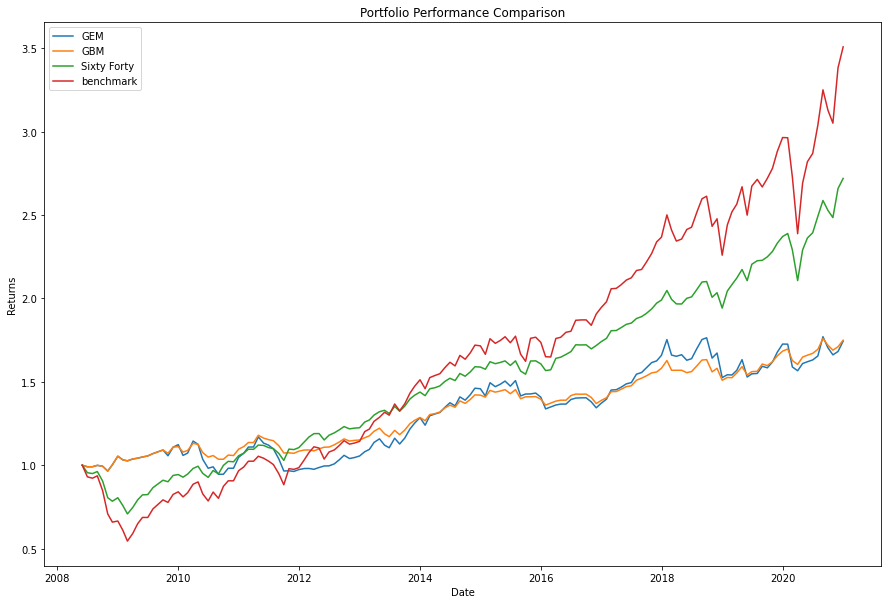

In [34]:
plt.figure(figsize=(15,10))
plt.plot(combined_df)
plt.legend(combined_df.columns)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Performance Comparison')